### Домашнее задание
Имеются данные adult.csv (см. в материалах к занятию).  
Целевой переменной является уровень дохода income (крайний правый столбец).  
Описание признаков можно найти по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html  
Вам необходимо построить модели логистической регрессии и SVM, которые предсказывает уровень дохода человека.  
Вывести качество полученных моделей на тестовой выборке, используя функцию score у модели.  
Готовый ноутбук выложить на гитхаб и прислать ссылку.

In [25]:
import pandas as pd
import pandas as np
import numpy as np
import csv
%pylab inline
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 10,10
pd.set_option('display.max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


In [9]:
#читаю файл
df = pd.read_csv('adult_csv.csv')  
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [13]:
#описание файла
df.describe()

,age,fnlwgt,education-num,capitalgain,capitalloss,hoursperweek
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,1.771078,1.896641e+05,10.078089,0.200319,0.114942,1.950698
std,1.295378,1.056040e+05,2.570973,0.746182,0.556924,0.897038
min,0.000000,1.228500e+04,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.175505e+05,9.000000,0.000000,0.000000,2.000000
50%,2.000000,1.781445e+05,10.000000,0.000000,0.000000,2.000000
75%,3.000000,2.376420e+05,12.000000,0.000000,0.000000,2.000000
max,4.000000,1.490400e+06,16.000000,4.000000,4.000000,4.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capitalgain     48842 non-null  int64 
 11  capitalloss     48842 non-null  int64 
 12  hoursperweek    48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  class           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### Пробую предсказать уровень дохода на основании четырех признаков:
* workclass    - принадлежность к какому-либо рабочему классу  
* education    - образование(использую его код)
* occupation   - профессия/род деятельности
* hoursperweek - к-во рабочих часов

In [4]:
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', nan, 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [5]:
df['hoursperweek'].unique()

array([2, 0, 3, 4, 1], dtype=int64)

In [6]:
df['education-num'].unique()

array([13,  9,  7, 14,  5, 10, 12, 11,  4, 16, 15,  3,  6,  2,  1,  8],
      dtype=int64)

In [7]:
df['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', nan, 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [15]:
#есть ли пустые значения
df[ pd.isnull( df['workclass'] ) ].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
27,3,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,3,South,>50K
61,1,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,2,NaN,<=50K
69,0,NaN,200681,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,2,United-States,<=50K
77,4,NaN,212759,10th,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,0,United-States,<=50K
106,0,NaN,304873,10th,6,Never-married,NaN,Own-child,White,Female,4,0,1,United-States,<=50K


In [21]:
print('Для workclass      пустых строк -  {}'.format( len( df[ pd.isnull( df['workclass'] ) ] ) ))
print('Для hoursperweek   пустых строк -  {}'.format( len( df[ pd.isnull( df['hoursperweek'] ) ] ) ))
print('Для education-num  пустых строк -  {}'.format( len( df[ pd.isnull( df['education-num'] ) ] ) ))
print('Для occupation     пустых строк -  {}'.format( len( df[ pd.isnull( df['occupation'] ) ] ) ))
print('Для class          пустых строк -  {}'.format( len( df[ pd.isnull( df['class'] ) ] ) ))
print('Всего строк                     -  {}'.format( len( df ) ))

Для workclass      пустых строк -  2799
Для hoursperweek   пустых строк -  0
Для education-num  пустых строк -  0
Для occupation     пустых строк -  2809
Для class          пустых строк -  0
Всего строк                     -  48842


In [22]:
#оставляю необходимые данные
df_w = df[['workclass','hoursperweek','education-num', 'occupation', 'class' ]]
df_w.head()

,workclass,hoursperweek,education-num,occupation,class
0,State-gov,2,13,Adm-clerical,<=50K
1,Self-emp-not-inc,0,13,Exec-managerial,<=50K
2,Private,2,9,Handlers-cleaners,<=50K
3,Private,2,7,Handlers-cleaners,<=50K
4,Private,2,13,Prof-specialty,<=50K


In [23]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   workclass      46043 non-null  object
 1   hoursperweek   48842 non-null  int64 
 2   education-num  48842 non-null  int64 
 3   occupation     46033 non-null  object
 4   class          48842 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


In [24]:
#удаляю пустые значения(на мой взгляд их немного)
df_w = df_w.dropna()
df_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46033 entries, 0 to 48841
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   workclass      46033 non-null  object
 1   hoursperweek   46033 non-null  int64 
 2   education-num  46033 non-null  int64 
 3   occupation     46033 non-null  object
 4   class          46033 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.1+ MB


<AxesSubplot:ylabel='class'>

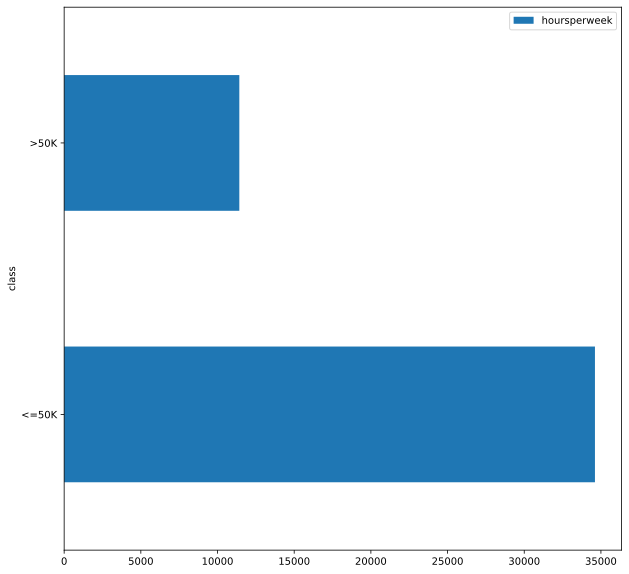

In [29]:
#смотрю количество 
df_w[['class', 'hoursperweek']].groupby('class').count().plot(kind='barh')

In [30]:
df_w.workclass.value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Name: workclass, dtype: int64

In [31]:
df_w.occupation.value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

In [34]:
#смотрю к-во столбцов,которые добавятся при переводе из категориальных
categoricals = ['workclass','occupation']
total = 0
for cat in categoricals:
    total += len(df_w[cat].unique())
    print(cat,':',len(df_w[cat].unique()))
print('Total:',total)

workclass : 7
occupation : 14
Total: 21


In [35]:
# оставляю признаки и выделяю целевую
selectedColumns = df_w[['workclass','hoursperweek','education-num', 'occupation' ]]
target = df_w['class']

# столбцы 'workclass','occupation' являются категориальными
# переведем их в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies( selectedColumns, columns = [ 'workclass','occupation' ] )

# столбец class является целевой переменной, удаляем его из X
X.head()

,hoursperweek,education-num,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,2,13,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,13,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,9,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,2,7,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
# целевая переменная (столбец class)  является категориальным
# перевожу значения столбца в числа, оставив один столбец

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [38]:
le.fit( target )

LabelEncoder()

In [39]:
le.classes_

array(['<=50K', '>50K'], dtype=object)

In [44]:
# пример "расшировки" столбца class

le.transform( [ '>50K', '<=50K', '>50K' ] )

array([1, 0, 1])

In [48]:
# записываю в переменную y преобразованный столбец class

y = pd.Series( data = le.transform( target ) )
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int32

In [49]:
lr = LogisticRegression()

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [51]:
X_train.shape, X_test.shape

((36826, 23), (9207, 23))

In [52]:
lr.fit(X_train, y_train )

C:\Users\Sergey\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
lr.score(X_train, y_train )

0.7839298321837832

In [54]:
lr.score(X_test, y_test)

0.782991202346041

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


pipe_model = make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000))

In [63]:
# обучаю модель

pipe_model.fit( X_train, y_train )
predictions = pipe_model.predict_proba( X_test )

In [64]:
y_pred = pipe_model.predict_proba(X_test)

In [65]:
pipe_model.score(X_train, y_train)

0.7837125943626786

In [66]:
pipe_model.score(X_test, y_test)

0.7830998153578799

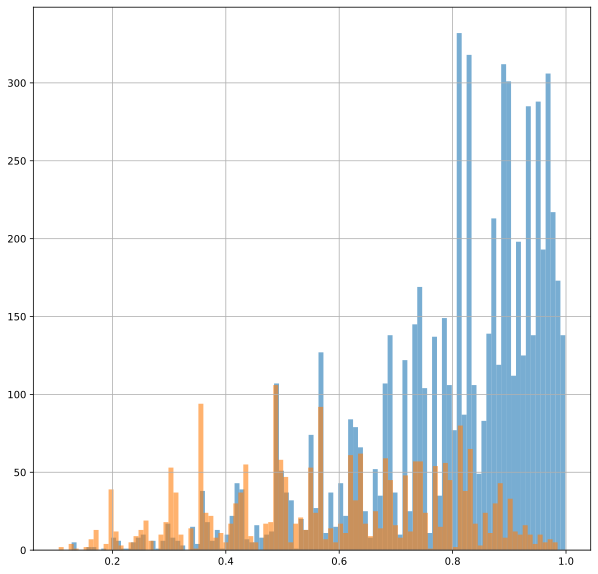

In [67]:
import matplotlib.pyplot as plt

_ = plt.hist(y_pred[y_test == 0][:,0], bins=100, alpha=0.6)
_ = plt.hist((1 - y_pred[y_test == 1][:,1]), bins=100, alpha=0.6)

plt.grid()

In [68]:
#строю модель SVM

from sklearn.svm import SVC


clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [69]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [70]:
clf.score(X_train, y_train)

0.7865366860370391

In [71]:
clf.score(X_test, y_test)

0.7839687194525904

In [72]:
svc = SVC(gamma='auto')

In [73]:
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [74]:
svc.score(X_train, y_train)

0.7847173192852875

In [75]:
svc.score(X_test, y_test)

0.7839687194525904